<a href="https://colab.research.google.com/github/jha-vineet69/Car-Damage-Detection/blob/main/Car_Damage_Detection_Step_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pipe1 : 
## To check if user input image is a car or not. Tested against multiple cnn frameworks to find one with maximum accuracy.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import h5py
import urllib.request
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pk
from IPython.display import Image, display, clear_output
from collections import Counter, defaultdict
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from keras import optimizers
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.utils.data_utils import get_file
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential, load_model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint, History

In [ ]:
CLASS_INDEX = None
CLASS_INDEX_PATH = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'

In [ ]:
vgg16 = VGG16(weights='imagenet')
vgg19 = VGG19(weights='imagenet')
resnet = ResNet50(weights='imagenet')
inception = InceptionV3(weights='imagenet')
xception = Xception(weights='imagenet')

91889664/91884032 [==============================] - 1s 0us/step


In [ ]:
def prepare_image_224(img_path):
    img = load_img(img_path, target_size=(224,224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [ ]:
def prepare_image_299(img_path):
    img = load_img(img_path, target_size=(299,299))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [ ]:
def get_predictions(preds, top=5):
    global CLASS_INDEX
    if len(preds.shape) != 2 or preds.shape[1] != 1000:
        raise ValueError('`decode_predictions` expects a batch of predictions (i.e. a 2D array of shape (samples, 1000)). Found array with shape: ' + str(preds.shape))
    if CLASS_INDEX is None:
        fpath = get_file('imagenet_class_index.json',CLASS_INDEX_PATH,cache_subdir='models')
        CLASS_INDEX = json.load(open(fpath))
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [tuple(CLASS_INDEX[str(i)]) + (pred[i],) for i in top_indices]
        result.sort(key=lambda x: x[2], reverse=True)
        results.append(result)
    return results

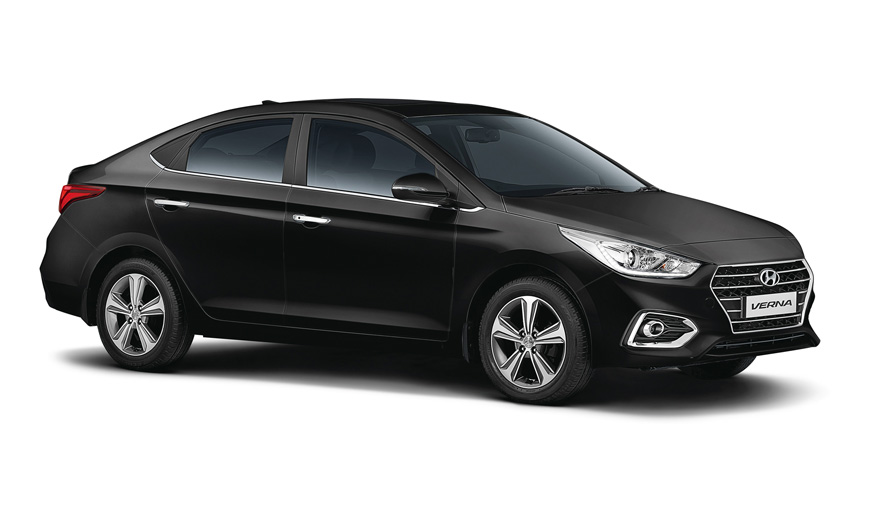

In [ ]:
test_image_path = 'http://cdni.autocarindia.com/ExtraImages/20180110122444_vernaz.jpg'
urllib.request.urlretrieve(test_image_path, 'image.jpg')
Image('image.jpg')

### Testing with different models 

In [ ]:
y = prepare_image_224('image.jpg')
preds = vgg16.predict(y)
print(get_predictions(preds, top=5))

[[('n03100240', 'convertible', 0.38258868), ('n02814533', 'beach_wagon', 0.25269294), ('n03770679', 'minivan', 0.08323025), ('n04285008', 'sports_car', 0.07361186), ('n02974003', 'car_wheel', 0.0648476)]]


In [ ]:
z = prepare_image_224('image.jpg')
preds = vgg19.predict(z)
print(get_predictions(preds, top=5))

[[('n03770679', 'minivan', 0.28246593), ('n02814533', 'beach_wagon', 0.17655627), ('n02974003', 'car_wheel', 0.15990372), ('n04037443', 'racer', 0.12617366), ('n04285008', 'sports_car', 0.09998078)]]


In [ ]:
a = prepare_image_224('image.jpg')
preds = resnet.predict(a)
print(get_predictions(preds))

[[('n03770679', 'minivan', 0.46334484), ('n03930630', 'pickup', 0.13273531), ('n02974003', 'car_wheel', 0.12972446), ('n02814533', 'beach_wagon', 0.08506718), ('n03459775', 'grille', 0.046393268)]]


In [ ]:
b = prepare_image_299('image.jpg')
preds = inception.predict(b)
print(get_predictions(preds, top=5))

[[('n06359193', 'web_site', 1.0), ('n03047690', 'clog', 1.2129241e-17), ('n04328186', 'stopwatch', 2.8840106e-21), ('n03481172', 'hammer', 2.7196682e-25), ('n04254777', 'sock', 2.548584e-25)]]


In [ ]:
c = prepare_image_299('image.jpg')
preds = xception.predict(c)
print(get_predictions(preds, top=5))

[[('n04127249', 'safety_pin', 0.9909314), ('n03775546', 'mixing_bowl', 0.0069652074), ('n03942813', 'ping-pong_ball', 0.0012593173), ('n03445777', 'golf_ball', 0.00084411213), ('n04149813', 'scoreboard', 2.589989e-12)]]


##### Result: VGG16 shows best accuracy.

## Using VGG16 model for Pipe1

In [ ]:
def get_car_categories():
    d = defaultdict(float)
    img_directory = '/content/drive/MyDrive/Colab Notebooks/Minor Project Sem 7/data1a/training/01-whole'
    img_list = os.listdir(img_directory)
    for i, img_path in enumerate(img_list):
        img = prepare_image_224(img_directory+'/'+img_path)
        out = vgg16.predict(img)
        preds = get_predictions(out,top=5)
        for pred in preds[0]:
            d[pred[0:2]]+=pred[2]
        if(i%100==0):
            print(i,'/',len(img_list),'complete')
    return Counter(d)

In [ ]:
categ_count = get_car_categories()

0 / 920 complete
100 / 920 complete
200 / 920 complete
300 / 920 complete
400 / 920 complete
500 / 920 complete
600 / 920 complete
700 / 920 complete
800 / 920 complete
900 / 920 complete


In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Minor Project Sem 7/vgg16_cat_list.pk', 'wb') as f:
    pk.dump(categ_count, f, -1)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Minor Project Sem 7/vgg16_cat_list.pk', 'rb') as f:
    categ_count = pk.load(f)

In [ ]:
categ_list = [k for k, v in categ_count.most_common()[:20]]

# Pipe 1

In [ ]:
def pipe1(img_path, categ_list):
    urllib.request.urlretrieve(img_path, 'image.jpg')
    img = prepare_image_224('image.jpg')
    out = vgg16.predict(img)
    preds = get_predictions(out, top=5)
    print("Ensuring entered picture is a car...")
    for pred in preds[0]:
        if pred[0:2] in categ_list:
            print(pred[0:2])
            return "Successful. Proceeding to damage assessment..."
    return "The entered image is a not a car. Please try again. Consider a different angle or lighting."

In [ ]:
pipe1('https://cdn.nba.net/nba-drupal-prod/2017-05/lonzo-ball-sideline-iso.jpg',categ_list)

Ensuring entered picture is a car...


'The entered image is a not a car. Please try again. Consider a different angle or lighting.'

In [ ]:
pipe1('https://tse4.mm.bing.net/th?id=OIP.FaZela57De0uzfVxVY3JJQHaEo&pid=Api&P=0&w=289&h=181', categ_list)

Ensuring entered picture is a car...
('n04037443', 'racer')


'Successful. Proceeding to damage assessment...'